# 인코딩(encoding)과 디코딩(decoding)

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 떄 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>


# 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>


### 원본 이미지 재구성

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [5]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder,self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim,activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(784,activation='sigmoid'),
        layers.Reshape((28,28))
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

- x_train을 입력과 대상으로 사용하여 모델은 훈련
- encoder는 데이터세트를 784차원에서 잠재 공간으로 압축
- decoder는 원본 이미지를 재구성

In [9]:
from re import X
autoencoder.fit(x_train, x_train, 
                epochs=10,
                shuffle=True,
                validation_data=(x_test,x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

In [11]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

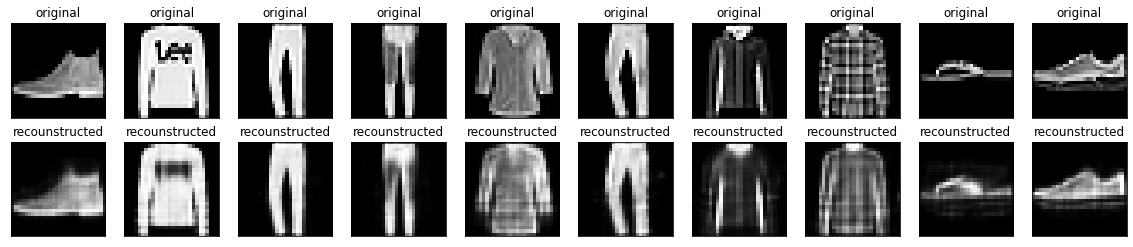

In [12]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  # display original
  ax = plt.subplot(2,n,i+1)
  plt.imshow(x_test[i])
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # diplay reconstruction
  ax = plt.subplot(2,n,i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title('recounstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


### 이미지 노이즈 제거

In [13]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()

In [14]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [16]:
# 이미지에 임의의 노이즈 추가
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

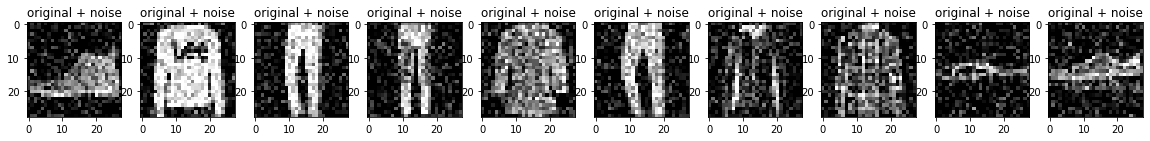

In [17]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
  plt.gray()
plt.show()

encoder에 Conv2D 레이어를 사용하고 decoder에 Conv2DTranspose 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련

In [18]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16,(3,3), activation='relu',padding='same', strides=2),
        layers.Conv2D(8,(3,3), activation='relu',padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8,kernel_size=3, activation='relu',padding='same', strides=2),
        layers.Conv2DTranspose(16,kernel_size=3, activation='relu',padding='same', strides=2),
        layers.Conv2DTranspose(1,kernel_size=(3,3), activation='sigmoid',padding='same')])
    
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()


In [19]:
autoencoder.compile(optimizer='adam',loss=losses.MeanSquaredError())

In [20]:
autoencoder.fit(x_train_noisy,x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy,x_test))

Epoch 1/10
1875/1875 [==============================] - 13s 3ms/step - loss: 0.0192 - val_loss: 0.0115
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

In [21]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

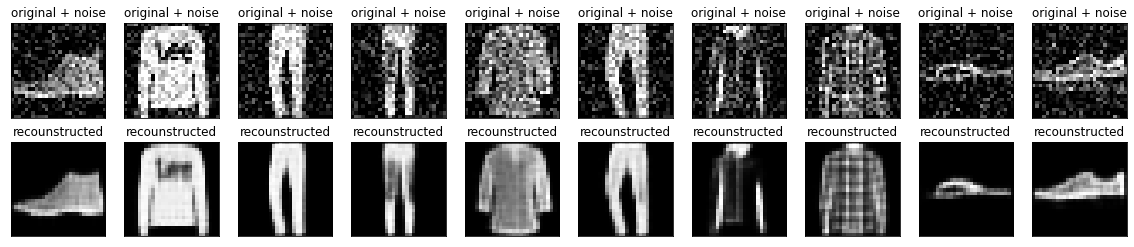

In [24]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  # display original + noise
  ax = plt.subplot(2,n,i+1)
  plt.title('original + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # diplay reconstruction
  ax = plt.subplot(2,n,i+1+n)  
  plt.title('recounstructed')
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 이상 감지

[ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.


In [26]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [27]:
dataframe.shape

(4998, 141)

In [28]:
dataframe.iloc[:,-1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [29]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]

train_data,test_data,train_labels, test_labels = train_test_split(data,labels,test_size=0.2,random_state=21)

In [30]:
# tf.cast 함수 : 텐서를 새로운 형태로 캐스팅하는데 시용

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [31]:
train_data.shape

TensorShape([3998, 140])

1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련

In [32]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [33]:
pd.Series(train_labels).value_counts()

True     2359
False    1639
dtype: int64

In [34]:
normal_train_data.shape

TensorShape([2359, 140])

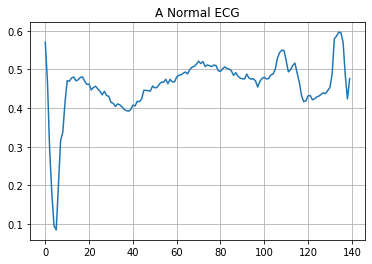

In [35]:
# 정상적인 ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

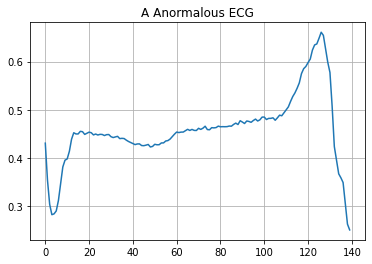

In [37]:
# 비정상적인 ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('A Anomalous ECG')
plt.show()

In [38]:
# 모델 빌드하기
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector,self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(32,activation='relu'),
        layers.Dense(16,activation='relu'),
        layers.Dense(8,activation='relu')])
    
    self.decoder = tf.keras.Sequential([
        layers.Dense(16,activation='relu'),
        layers.Dense(32,activation='relu'),
        layers.Dense(140,activation='sigmoid')])
    
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
   

In [40]:
autoencoder.compile(optimizer='adam', loss='mae')

In [41]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs = 20,
                          batch_size=512,
                          validation_data=(test_data,test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 34ms/step - loss: 0.0583 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0559 - val_loss: 0.0518
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0531 - val_loss: 0.0501
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0490 - val_loss: 0.0483
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.0459
Epoch 6/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.0438
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0420
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0329 - val_loss: 0.0407
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0306 - val_loss: 0.0397
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0289 - val_loss: 0.0387
Epoch 11/20
5/5 [=====================

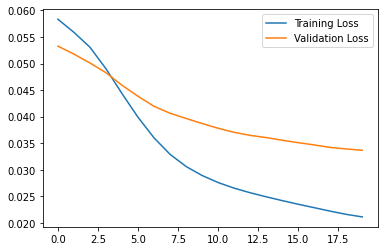

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

- 재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우 ECG 비정상으로 분류
- 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성 오류 플롯팅

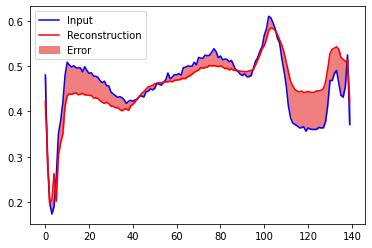

In [43]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

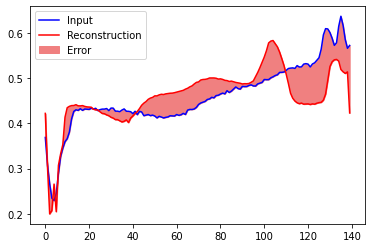

In [45]:
# 비정상적인 테스트 플롯
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

- 재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상치 감지
- 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음 재구성 오류가 훈련세트의 표준편차 보다 큰 경우 비정상적인 것으로 분류 

74/74 [==============================] - 0s 1ms/step


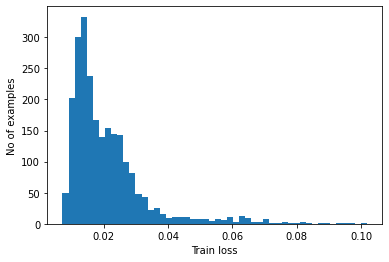

In [46]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss,bins=50)
plt.xlabel('Train loss')
plt.ylabel('No of examples')
plt.show()

In [47]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('임계치:', threshold )

임계치: 0.033142805


14/14 [==============================] - 0s 1ms/step


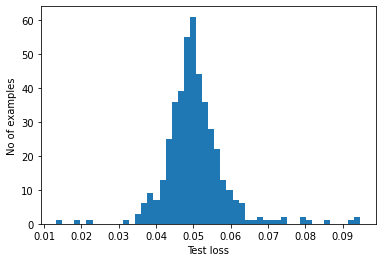

In [50]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.show()

In [51]:
def predict(model, data,threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss,threshold)

preds = predict(autoencoder, test_data, threshold)
print(preds[:10])

tf.Tensor([False False  True  True False False  True  True False  True], shape=(10,), dtype=bool)


In [52]:
def print_stats(predictions, labels):
  print('Accuracy = {}'.format(accuracy_score(labels,preds)))
  print('Precision = {}'.format(precision_score(labels,preds)))
  print('Recall = {}'.format(recall_score(labels,preds)))

print_stats(preds,test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714
